In [1]:
import pickle
import visualkeras
from tqdm import tqdm
import numpy as np
import pandas as pd
import skimage
from skimage import io
import tifffile as tifi
from skimage.io import imread_collection
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image, ImageFont
from collections import defaultdict
import os, re, sys, random, shutil, cv2

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import VGG16, VGG19, DenseNet121, InceptionResNetV2, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler

# loading data


In [3]:
data_dir = "Dataset\Prepared_Dataset"

train_images = os.path.join(data_dir, "train_images/")
train_masks = os.path.join(data_dir, "train_masks/")
val_images = os.path.join(data_dir, "val_images/")
val_masks = os.path.join(data_dir, "val_masks/")
test_images = os.path.join(data_dir, "test_images/")
test_masks = os.path.join(data_dir, "test_masks/")


In [4]:
import os
print('Number of images in training set: ', len(os.listdir(train_images+'train')))
print('Number of masks in training set: ', len(os.listdir(train_masks+'train')))
print('Number of images in validation set: ', len(os.listdir(val_images+'valid')))
print('Number of masks in validation set: ', len(os.listdir(val_masks+'valid')))
print('Number of images in testing set: ', len(os.listdir(test_images+'test')))
print('Number of masks in testing set: ', len(os.listdir(test_masks+'test')))

Number of images in training set:  7128
Number of masks in training set:  7128
Number of images in validation set:  891
Number of masks in validation set:  891
Number of images in testing set:  891
Number of masks in testing set:  891


# plotting satellite images vs ground truth images


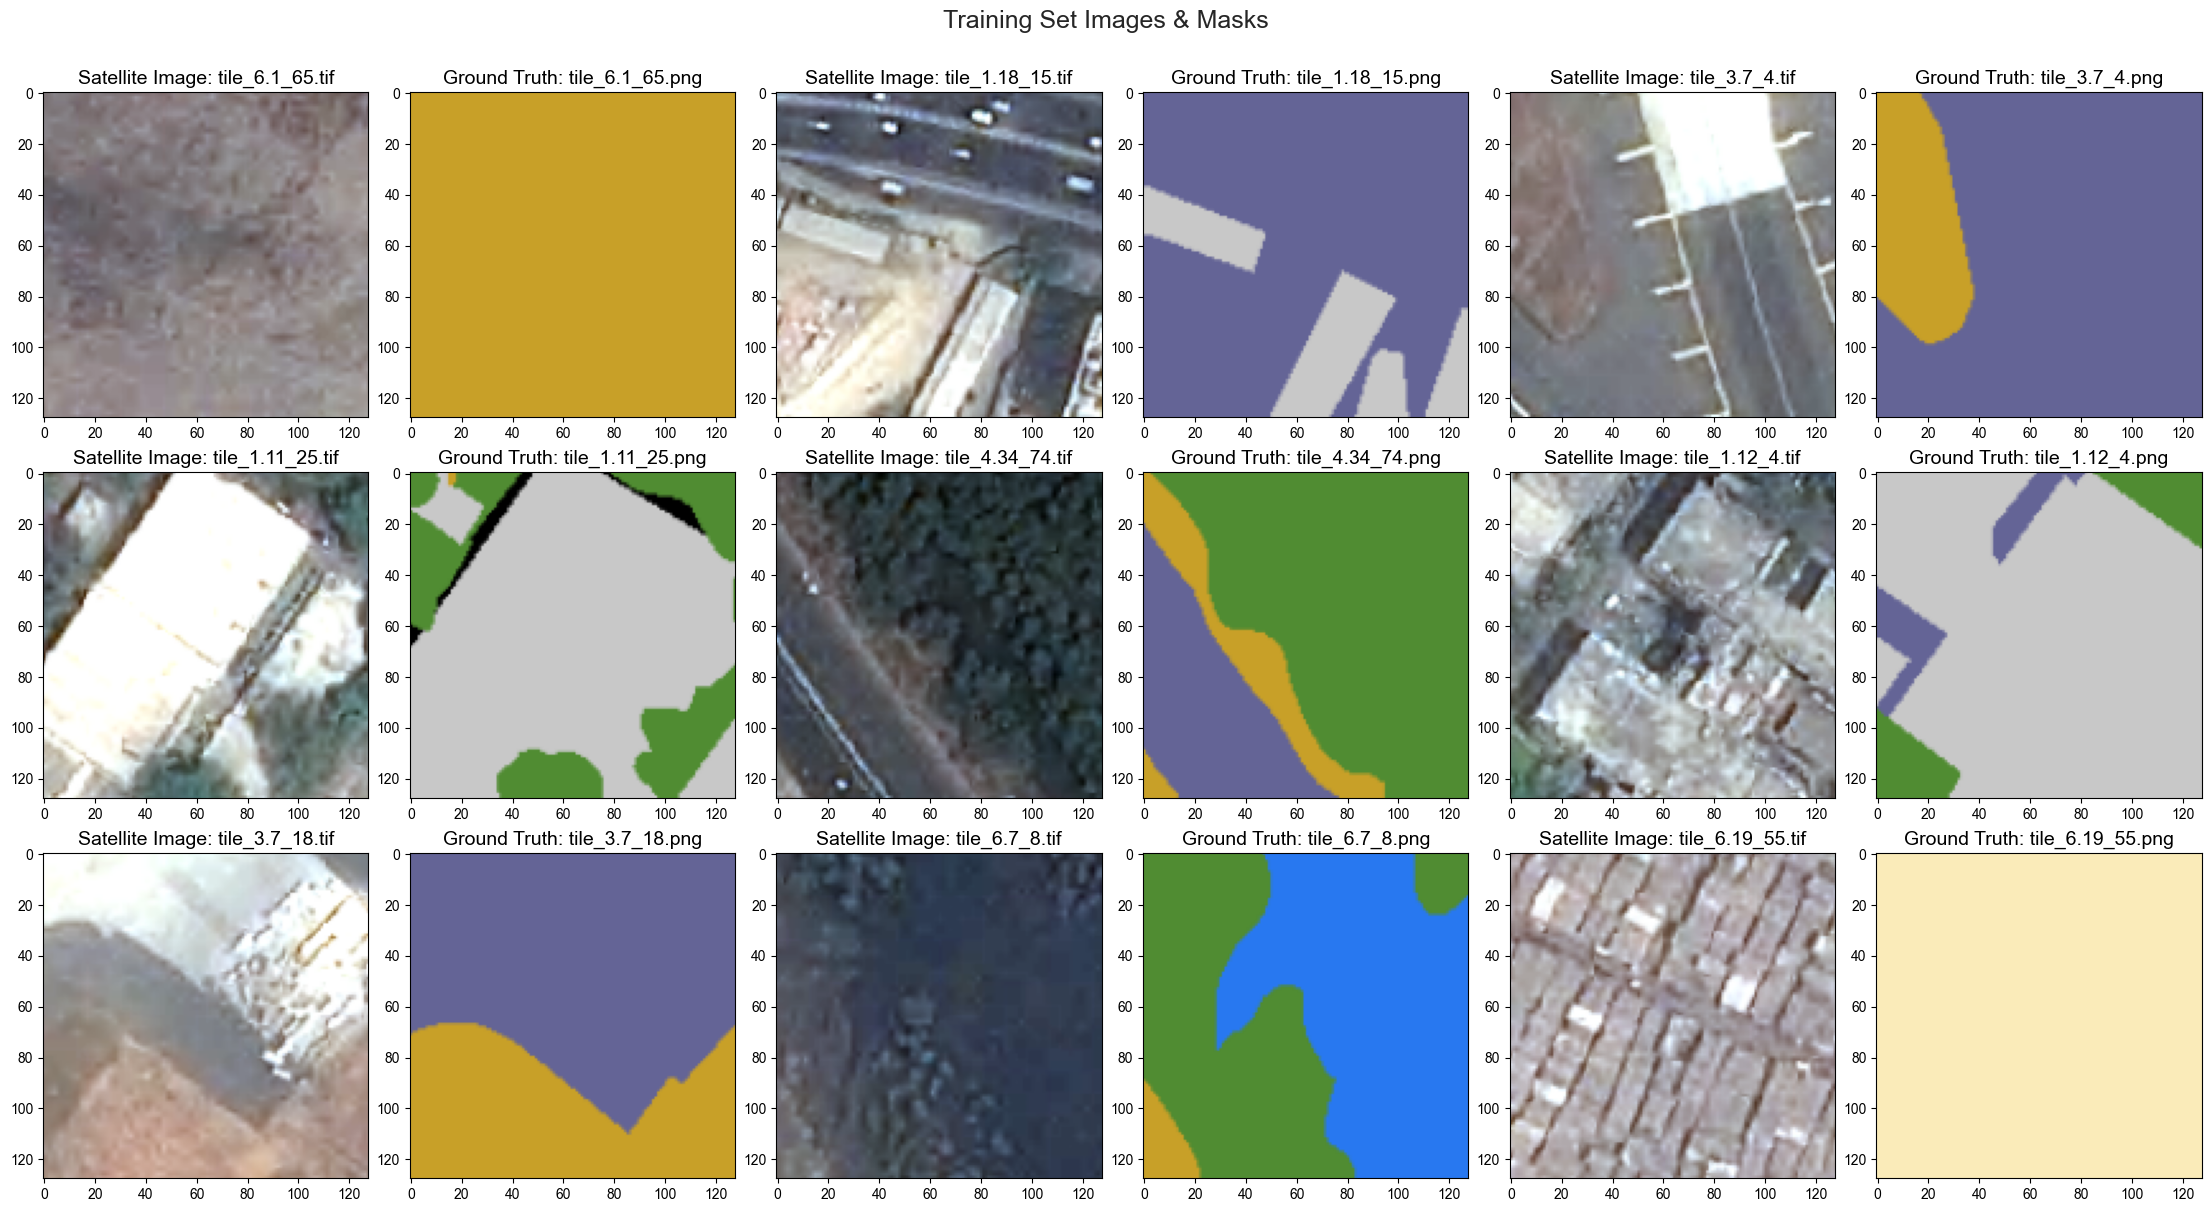

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

files = ['tile_6.1_65', 'tile_1.18_15', 'tile_3.7_4', 'tile_1.11_25', 'tile_4.34_74', 'tile_1.12_4', 'tile_3.7_18', 'tile_6.7_8', 'tile_6.19_55']

def show_data(files, images_dir, masks_dir):
        fig, axs = plt.subplots(3, 6, figsize=(22, 12), constrained_layout=True)
        sns.set_style("ticks")
        fig.suptitle('Training Set Images & Masks\n', fontsize=18, fontweight='medium')
        idx = 0
        for i in range(3):
            for j in range(6):
                if j%2 == 0:
                    axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(f'{images_dir}train/{files[idx]}.tif'), cv2.COLOR_BGR2RGB),(128, 128)))
                    axs[i][j].set_title(f'Satellite Image: {files[idx]}.tif', fontdict = {'fontsize':14, 'fontweight':'medium'})
                    axs[i][j].grid(False)
                    axs[i][j].axis(True)
                elif j%2 != 0:
                        axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(f'{masks_dir}train/{files[idx]}.png'), cv2.COLOR_BGR2RGB),(128, 128)))
                        axs[i][j].set_title(f'Ground Truth: {files[idx]}.png', fontdict = {'fontsize':14, 'fontweight':'medium'})
                        axs[i][j].grid(False)
                        axs[i][j].axis(True)
                        idx += 1
                        
        plt.savefig('output/img1', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 300)
        plt.show()

show_data(files, train_images, train_masks)

In [6]:
import pandas as pd
class_df = pd.read_csv('Dataset\Main_Dataset\class_dict.csv', index_col=False, skipinitialspace=True)
class_df

,name,r,g,b
0,Informal Settlements,250,235,185
1,Built-Up,200,200,200
2,Impervious Surfaces,100,100,150
3,Vegetation,80,140,50
4,Barren,200,160,40
5,Water,40,120,240
6,Unlabelled,0,0,0


In [7]:
import numpy as np
label_names= list(class_df.name)
label_codes = []
r= np.asarray(class_df.r)
g= np.asarray(class_df.g)
b= np.asarray(class_df.b)

for i in range(len(class_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

([(250, 235, 185),
  (200, 200, 200),
  (100, 100, 150),
  (80, 140, 50),
  (200, 160, 40),
  (40, 120, 240),
  (0, 0, 0)],
 ['Informal Settlements',
  'Built-Up',
  'Impervious Surfaces',
  'Vegetation',
  'Barren',
  'Water',
  'Unlabelled'])

In [8]:
code_to_id = {v:k for k,v in enumerate(label_codes)}
id_to_code = {k:v for k,v in enumerate(label_codes)}

name_to_id = {v:k for k,v in enumerate(label_names)}
id_to_name = {k:v for k,v in enumerate(label_names)}

name_to_code={label_names[i]:label_codes[i] for i in range(len(label_names))}

In [9]:
id_to_code

{0: (250, 235, 185),
 1: (200, 200, 200),
 2: (100, 100, 150),
 3: (80, 140, 50),
 4: (200, 160, 40),
 5: (40, 120, 240),
 6: (0, 0, 0)}

In [10]:
id_to_name

{0: 'Informal Settlements',
 1: 'Built-Up',
 2: 'Impervious Surfaces',
 3: 'Vegetation',
 4: 'Barren',
 5: 'Water',
 6: 'Unlabelled'}

In [11]:
name_to_code

{'Informal Settlements': (250, 235, 185),
 'Built-Up': (200, 200, 200),
 'Impervious Surfaces': (100, 100, 150),
 'Vegetation': (80, 140, 50),
 'Barren': (200, 160, 40),
 'Water': (40, 120, 240),
 'Unlabelled': (0, 0, 0)}

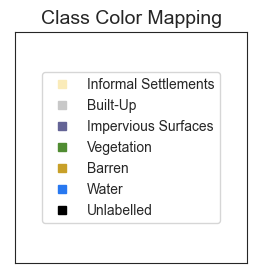

In [12]:

# Create a plot
fig, ax = plt.subplots(figsize=(3, 3))

# Plot each class color
for label, color in name_to_code.items():
    ax.plot([], [], 's', color=[c / 255. for c in color], label=label)

# Add legend
ax.legend(loc='center', fontsize=10)

# Remove ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# # Add title
ax.set_title('Class Color Mapping', fontsize=14)

plt.show()

# One hot encoding and decoding


In [13]:
def rgb_to_onehot(rgb_image, color_map = id_to_code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (e.g., 256 x 256 x 3 dimension numpy ndarray)
            color_map - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(color_map)
    '''
    num_classes = len(color_map)
    shape = rgb_image.shape[:2] + (num_classes,)
    encoded_image = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_map):
        encoded_image[:,:,i] = np.all(rgb_image.reshape((-1, 3)) == color_map[i], axis=1).reshape(shape[:2])
    return encoded_image

def onehot_to_rgb(onehot, color_map = id_to_code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            color_map - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2] + (3,))
    for k in color_map.keys():
        output[single_layer==k] = color_map[k]
    return np.uint8(output)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)
test_frames_datagen = ImageDataGenerator(**data_gen_args)
test_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

# Image data Generators


In [15]:
# data_dir = "Dataset\Prepared_Dataset"

# train_images = os.path.join(data_dir, "train", "images")
# print(train_images)
# train_masks = os.path.join(data_dir, "train", "masks")
# val_images = os.path.join(data_dir, "val", "images")
# val_masks = os.path.join(data_dir, "val", "masks")
# test_images = os.path.join(data_dir, "test", "images")
# test_masks = os.path.join(data_dir, "test", "masks")


In [16]:
def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id_to_code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):

    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id_to_code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
        
def TestAugmentGenerator(test_images_dir, test_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            test_images_dir - testing images directory
            test_masks_dir - testing masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    test_image_generator = test_frames_datagen.flow_from_directory(
    test_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    test_mask_generator = test_masks_datagen.flow_from_directory(
    test_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        X1i = test_image_generator.next()
        X2i = test_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id_to_code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

# MobileNetV2 Encoder Based UNet


In [22]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)

    return x

def build_mobilenetv2_unet(input_shape, num_classes):   
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained MobileNetV2 """
    encoder = MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs, alpha=1.4)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output                
    s2 = encoder.get_layer("block_1_expand_relu").output    
    s3 = encoder.get_layer("block_3_expand_relu").output    
    s4 = encoder.get_layer("block_6_expand_relu").output    

    """ Bridge """
    b1 = encoder.get_layer("block_13_expand_relu").output   

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                         
    d2 = decoder_block(d1, s3, 256)                         
    d3 = decoder_block(d2, s2, 128)                         
    d4 = decoder_block(d3, s1, 64)                          
    
    """ Dropout """
    x1 = Dropout(0.4)(d4)
    
    """ Output """
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(x1)

    model = Model(inputs, outputs, name="MobileNetV2-UNet")
    return model

In [23]:
K.clear_session()

loss = tf.keras.losses.CategoricalCrossentropy()
mobilenetv2_unet = build_mobilenetv2_unet(input_shape = (128, 128, 3), num_classes = 7)
mobilenetv2_unet.compile(optimizer=Adam(learning_rate = 0.0001), loss=loss, metrics=[dice_coef, "accuracy"])
mobilenetv2_unet.summary()

17831080/17831080 [==============================] - 27s 2us/step
Model: "MobileNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 48)   1296        ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 48)   192         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU

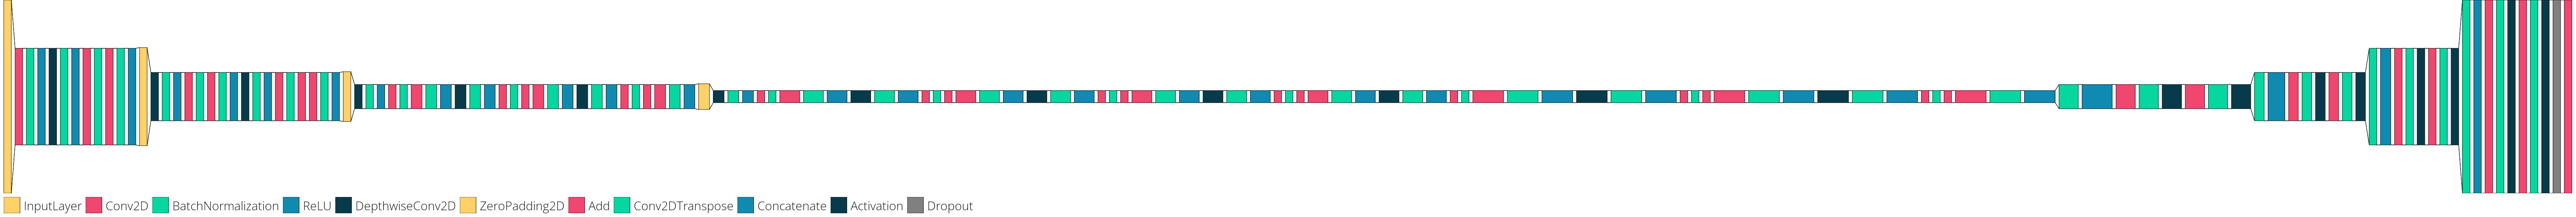

In [25]:
color_map = defaultdict(dict)
color_map[Dropout]['fill'] = 'gray'

font = ImageFont.truetype("OpenSans-Light.ttf", 32)
visualkeras.layered_view(mobilenetv2_unet, legend=True, font=font, to_file='./Output/mobilenetv2_unet_architecture.png', color_map=color_map, draw_volume=False)

# MobileNetV2-UNet Model Training


In [26]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 40)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = './Output/mobilenetv2_unet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

# earlystop = EarlyStopping(
#     monitor = 'val_loss', 
#     min_delta = 0.001, 
#     patience = 10, 
#     mode = 'auto', 
#     verbose = 1,
#     restore_best_weights = True
# )

csvlogger = CSVLogger(
    filename= "./Output/mobilenetv2_unet_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, csvlogger, lr_scheduler]

In [29]:
steps_per_epoch=3
history_3 = mobilenetv2_unet.fit(
    TrainAugmentGenerator(train_images_dir = train_images, train_masks_dir = train_masks, target_size = (128, 128)), 
    steps_per_epoch = steps_per_epoch,
    validation_data = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (128, 128)), 
    validation_steps = validation_steps, 
    epochs = 4, # 40
    callbacks = callbacks,
    use_multiprocessing = False,
    verbose = 1
)

Found 7128 images belonging to 1 classes.
Found 7128 images belonging to 1 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/4
3/3 [==============================] - ETA: 0s - loss: 0.6652 - dice_coef: 0.6400 - accuracy: 0.8016Found 891 images belonging to 1 classes.
Found 891 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 1.05586, saving model to ./Output\mobilenetv2_unet.h5
3/3 [==============================] - 40s 18s/step - loss: 0.6652 - dice_coef: 0.6400 - accuracy: 0.8016 - val_loss: 1.0559 - val_dice_coef: 0.4611 - val_accuracy: 0.6651 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.440608762859235e-05.
Epoch 2/4
3/3 [==============================] - ETA: 0s - loss: 1.0060 - dice_coef: 0.5749 - accuracy: 0.7179
Epoch 2: val_loss improved from 1.05586 to 1.00058, saving model to ./Output\mobilenetv2_unet.h5
3/3 [==============================] - 36s 16s/step - loss: 1.0060 - dice_coef: 0.5749 -

In [30]:
with open('./Output/trainHistoryDict_mobilenetv2_unet', 'wb') as file_pi:
    pickle.dump(history_3.history, file_pi)

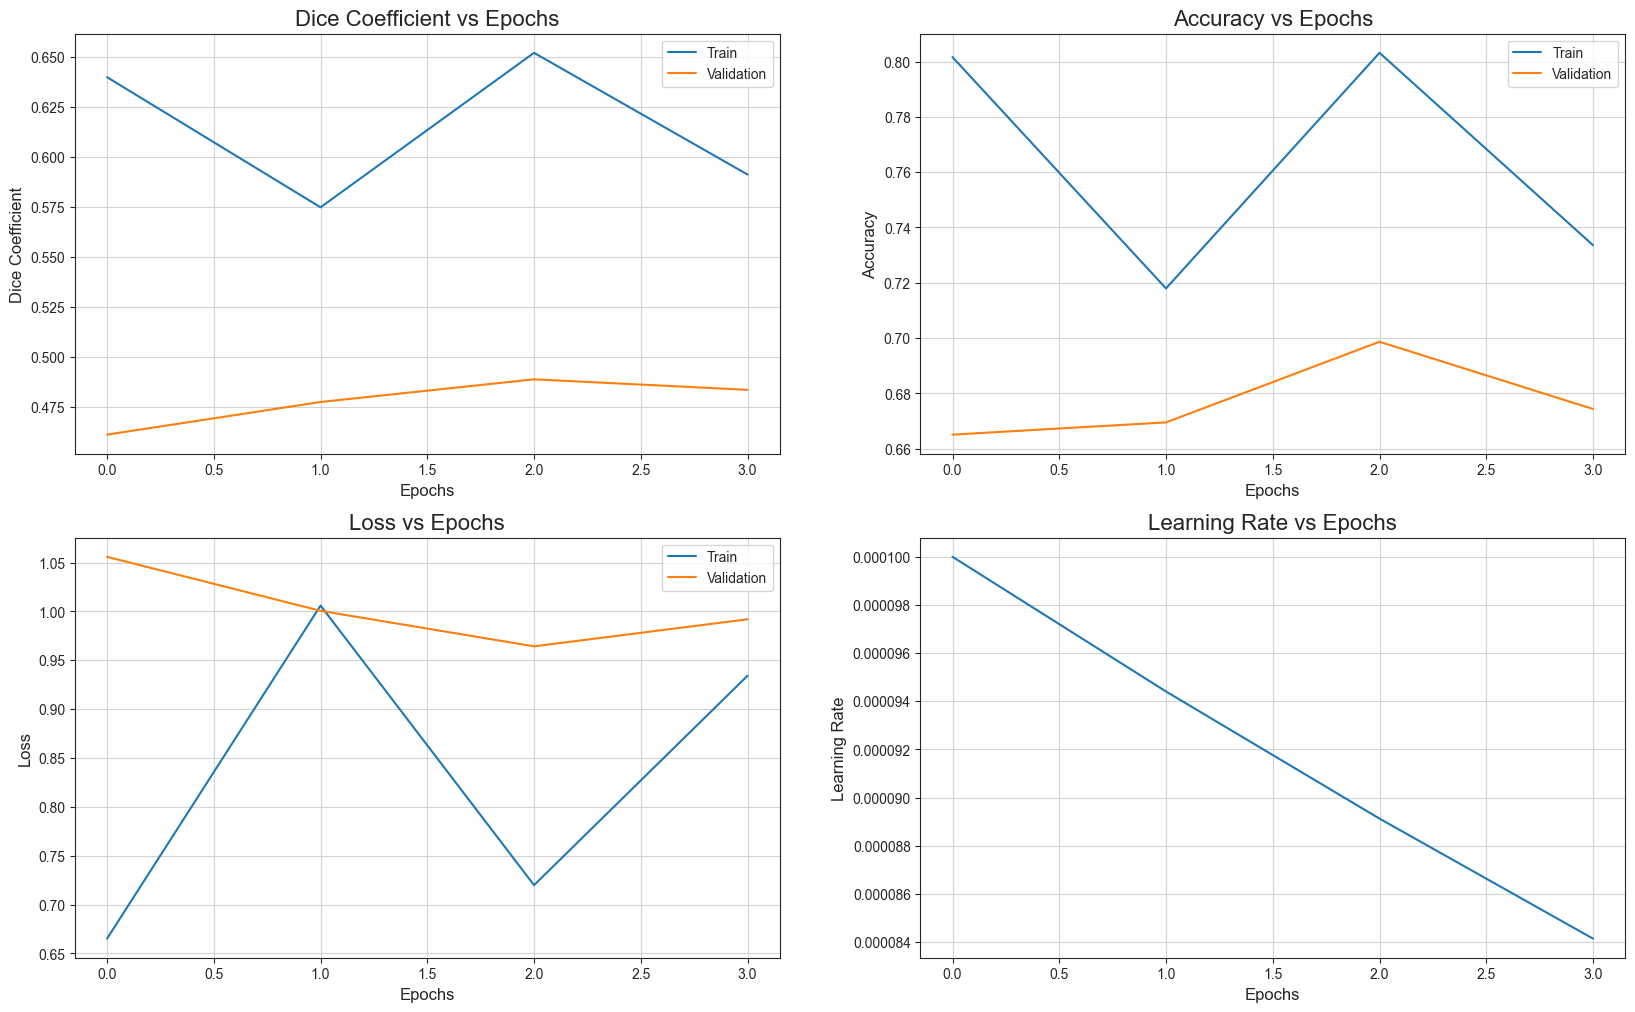

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()
sns.set_style("ticks")

metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history_3.history[met], '-')
        ax[i].plot(history_3.history['val_' + met], '-')
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs', fontsize=12)
        ax[i].set_ylabel(metrics[i], fontsize=12)
#         ax[i].set_xticks(np.arange(0,100,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history_3.history[met], '-')
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs', fontsize=12)
        ax[i].set_ylabel(metrics[i], fontsize=12)
#         ax[i].set_xticks(np.arange(0,100,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('./Output/mobilenetv2_unet_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 300)

# Evaluating MobileNetV2-UNet Model on Test Set


In [34]:
testing_gen = TestAugmentGenerator(test_images_dir = test_images, test_masks_dir = test_masks, batch_size = 32, target_size = (128, 128))
mobilenetv2_unet.load_weights("./Output/mobilenetv2_unet.h5")
mobilenetv2_unet_eval = mobilenetv2_unet.evaluate(testing_gen, steps=21, return_dict=True)
scores['mobilenetv2_unet'] = mobilenetv2_unet_eval

Found 891 images belonging to 1 classes.
Found 891 images belonging to 1 classes.
21/21 [==============================] - 67s 3s/step - loss: 1.1286 - dice_coef: 0.4328 - accuracy: 0.5774


In [43]:
Y_true_all_3, y_pred_all_3 = np.array([]), np.array([])
count = 0

for i in range(21):
    batch_img, batch_mask = next(testing_gen)
    pred_all= mobilenetv2_unet.predict(batch_img)
    
    for j in range(0,np.shape(pred_all)[0]):
        count += 1
        true_msk = batch_mask[j]
        pred_msk = pred_all[j]
        Y_true = np.argmax(true_msk, axis=-1) # Convert one-hot to index
        y_pred = np.argmax(pred_msk, axis=-1) # Convert one-hot to index

        Y_true_flat = Y_true.flatten()
        y_pred_flat = y_pred.flatten()
            
        Y_true_all_3 = np.append(Y_true_all_3, Y_true_flat)
        y_pred_all_3 = np.append(y_pred_all_3, y_pred_flat)

1/1 [==============================] - 3s 3s/step


In [44]:
print(Y_true_all_3.shape, y_pred_all_3.shape)

(11010048,) (11010048,)


In [45]:
print('Accuracy:', accuracy_score(Y_true_all_3, y_pred_all_3))
print('Precision:', precision_score(Y_true_all_3, y_pred_all_3, average='weighted'))
print('Recall:', recall_score(Y_true_all_3, y_pred_all_3, average='weighted'))
print('F1 Score:', f1_score(Y_true_all_3, y_pred_all_3, average='weighted'))

Accuracy: 0.571014404296875


c:\Users\Akshara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7290421428136336
Recall: 0.571014404296875
F1 Score: 0.5029926511843325


In [46]:
print(classification_report(Y_true_all_3, y_pred_all_3))


c:\Users\Akshara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Akshara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.33      0.99      0.49   1064602
         1.0       0.94      0.18      0.30    871537
         2.0       0.44      0.82      0.57   1874939
         3.0       0.99      0.17      0.29   2206084
         4.0       0.63      0.06      0.10   1901135
         5.0       0.86      0.99      0.92   3091742
         6.0       0.00      0.00      0.00         9

    accuracy                           0.57  11010048
   macro avg       0.60      0.46      0.38  11010048
weighted avg       0.73      0.57      0.50  11010048



c:\Users\Akshara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


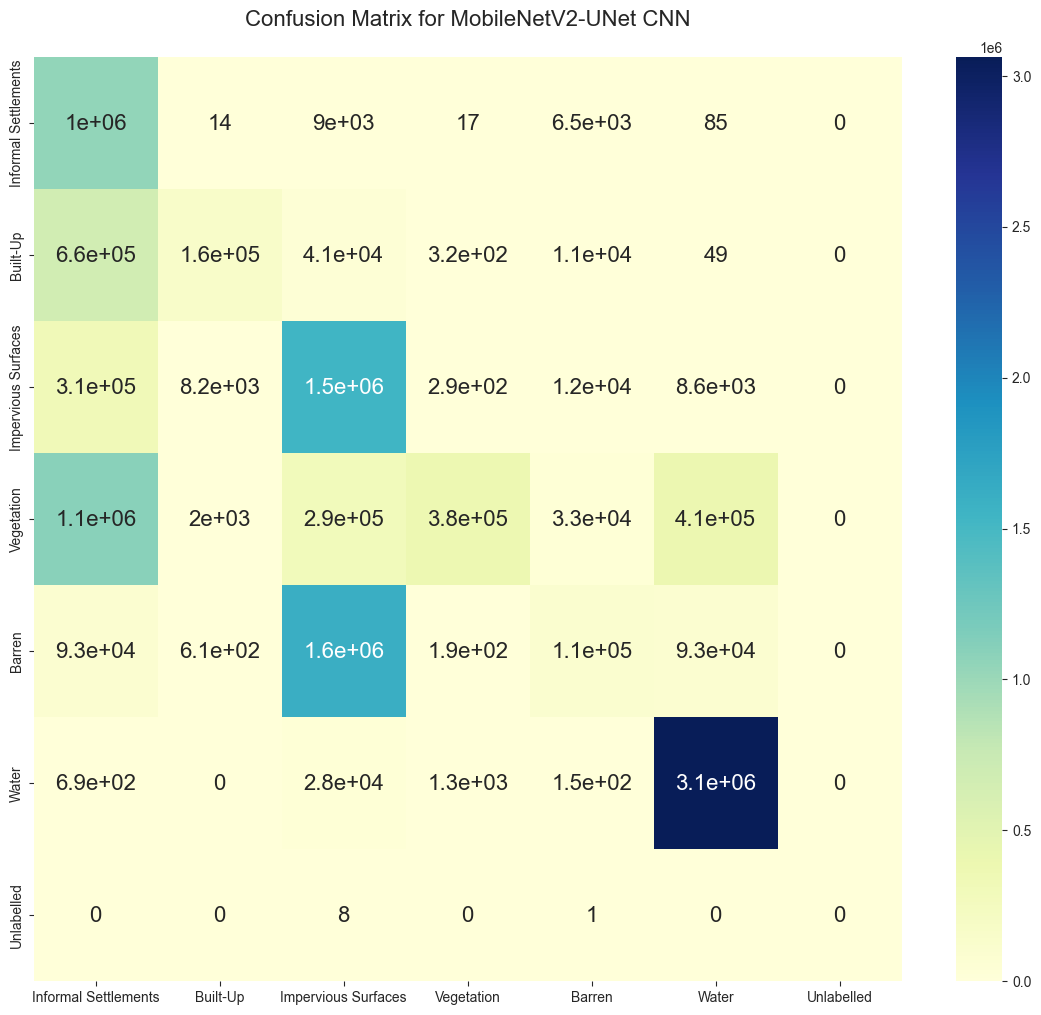

In [47]:
cm_3 = confusion_matrix(Y_true_all_3, y_pred_all_3)
df_cm_3 = pd.DataFrame(cm_3, label_names, label_names)
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(df_cm_3, annot=True, annot_kws={"size": 16}, cmap=plt.cm.YlGnBu)
plt.title('Confusion Matrix for MobileNetV2-UNet CNN\n', fontsize=16)
plt.savefig('./Output/confusion_matrix_3.png', transparent= False, bbox_inches= 'tight', dpi= 300)
plt.show()



In [48]:
per_class_acc_3 = class_accuracy(cm_3)
per_class_acc_3
mobilenetv2_unet_class_acc = pd.DataFrame(zip(label_names, per_class_acc_3[:6].T), columns=['Class', 'Accuracy'])
mobilenetv2_unet_class_acc['F1'] = f1_score(Y_true_all_3, y_pred_all_3, average=None)[:6]
mobilenetv2_unet_class_acc

,Class,Accuracy,F1
0,Informal Settlements,0.985366,0.490485
1,Built-Up,0.180517,0.302650
2,Impervious Surfaces,0.818031,0.569680
3,Vegetation,0.171433,0.292446
4,Barren,0.056353,0.103458
5,Water,0.990205,0.919244


C:\Users\Akshara\AppData\Local\Temp\ipykernel_25996\2657684996.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Accuracy", data=mobilenetv2_unet_class_acc, palette='turbo', alpha = 0.8)


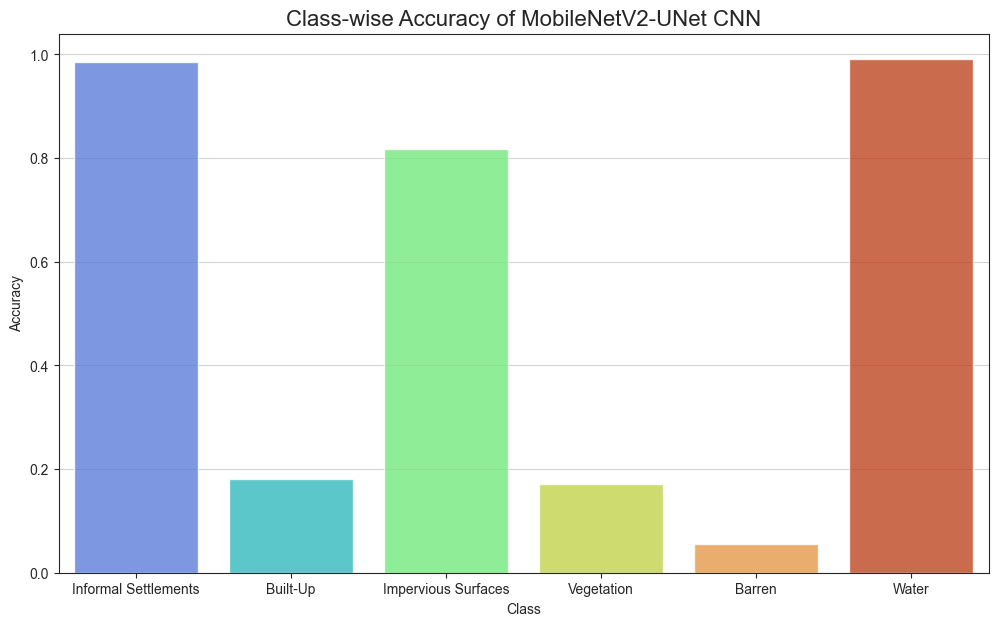

In [49]:
plt.figure(figsize=(12, 7))
plt.title('Class-wise Accuracy of MobileNetV2-UNet CNN', fontsize=16)
sns.set_style("ticks")
sns.barplot(x="Class", y="Accuracy", data=mobilenetv2_unet_class_acc, palette='turbo', alpha = 0.8)
plt.grid(axis='y', color = 'lightgray', linestyle='-', linewidth=0.8)
plt.savefig('./Output/mobilenetv2_unet_class_acc', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 300)
plt.show()

# Predictions on Test Set Using MobileNetV2-UNet Model


In [ ]:

count = 0
for i in range(5):
    batch_img,batch_mask = next(testing_gen)
    pred_all= mobilenetv2_unet.predict(batch_img)
    np.shape(pred_all)
    
    for j in range(0,np.shape(pred_all)[0]):
        count += 1
        fig = plt.figure(figsize=(20,8))

        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(batch_img[j])
        ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax1.set_xticks(np.arange(0, 129, 16))
        ax1.set_yticks(np.arange(0, 129, 16))
        ax1.grid(False)

        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax2.imshow(onehot_to_rgb(batch_mask[j],id_to_code))
        ax2.set_xticks(np.arange(0, 129, 16))
        ax2.set_yticks(np.arange(0, 129, 16))
        ax2.grid(False)

        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax3.imshow(onehot_to_rgb(pred_all[j],id_to_code))
        ax3.set_xticks(np.arange(0, 129, 16))
        ax3.set_yticks(np.arange(0, 129, 16))
        ax3.grid(False)

        plt.savefig('./Output/mobilenetv2_unet_pred/mobilenetv2_unet_pred_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
        plt.show()